# Feature detection and matching

## Motivation

Features are used for:
- Automatic panoramas
- Indexing and content-based retrieval (ex: Google images,...)
- Object recognition
- 3D reconstruction
- Motion tracking
- Robot navigation
- ...

## Which features are good to choose

*Choose features that are invariant to transformations*

**Invariant local features**
- Corners
- Blobs
- ...

**Advantages of local features**:
- Locality: robust to occlusion and clutter
- Quantity: hundreds or thousands in a single image
- Distinctiveness: can differentiate a large database of objects
- Efficiency: real-time performance achievable

*What about edges*
- Edges can be invariant to brightness changes but typically not invariant to other transformations

*Note on transformations*:
- Geometric invariance: translation, rotation, scale
- Photometric invariance: brightness, exposure

**Idea to measure the uniqueness of a feature**
- Consider a small window of pixels
- "Observe" how does the window change when you shift it
    - "flat" region: no change in all directions
    - "edge" region: no change along the edge direction
    - "corner": significant change in all directions

# Harris corner detection

Consider shifting the window $W$ by $(u,v)$

Sum of squared differences **(SSD "error")**:
$$
E(u,v) = \sum_{(x,y)\in W} (I(x+u, y+v) - I(x, y))^2
$$


If the motion $(u,v)$ is small, we can calculate the **approximation of** $I(x+u,y+v)$ using Taylor Series:
$$
\begin{aligned}
    I(x+u,y+v)
        & \approx I(x,y) + \frac{\partial I}{\partial x}u + \frac{\partial I}{\partial y}v \\
        & \approx I(x,y) + I_x u + I_y v   \\
        & \approx I(x,y) + \begin{bmatrix} I_x & I_y \end{bmatrix}
                           \begin{bmatrix} u \\ v \end{bmatrix}
\end{aligned}
$$

Plug the approximate $I(x+u,y+v)$ formula into $E$, we have:
$$
\begin{aligned}
    E(u,v)
        & = \sum_{(x,y)\in W} (I(x+u, y+v) - I(x, y))^2 \\
        & \approx \sum_{(x,y) \in W} (I(x,y) + I_x u + I_y v - I(x,y))^2 \\
        & \approx \sum_{(x,y) \in W} (I_x u + I_y v)^2 \\
        & \approx \sum_{(x,y) \in W} (I_x^2 u^2 + 2I_xI_yuv + I_y^2 v^2)
\end{aligned}
$$


## Derivative of an image

*Note: Differentiating an image in X and Y:*
$$
I_x = \frac{\partial I}{\partial x} \approx F(x+1,y) - F(x,y)
$$
$$
I_y = \frac{\partial I}{\partial y} \approx F(x,y+1) - F(x,y)
$$

In [11]:
import numpy as np
from typing import Tuple
def derivative(image: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    I_x1 = np.vstack([image[1:,:], np.zeros((1, image.shape[1]), dtype=np.int)])
    I_y1 = np.hstack([image[:,1:], np.zeros((image.shape[0], 1), dtype=np.int)])

    Ix = I_x1 - image
    Iy = I_x1 - image

    return Ix, Iy


In [24]:
import cv2
from cv2 import COLOR_BGR2RGB
from cv2 import COLOR_BGR2GRAY

import numpy as np

from matplotlib import pyplot as plt

def imshow(*imgs):
    fig=plt.figure(figsize=(8, 8))
    columns = len(imgs)
    rows = 1
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        if len(imgs[i-1].shape) == 2:
            plt.imshow(imgs[i-1], cmap='gray')
        else:
            plt.imshow(imgs[i-1])
    plt.show()

In [7]:
image_file = '../images/bird2.jpg'

tmp  = cv2.imread(image_file)
h, w = tmp.shape[0], tmp.shape[1]
new_h = 500
new_w = new_h * w // h

F_bgr  = cv2.resize(tmp, (new_h,new_w))
F_gray = cv2.cvtColor(tmp, COLOR_BGR2GRAY)
F_rgb  = cv2.cvtColor(tmp, COLOR_BGR2RGB)

In [25]:
Ix, Iy = derivative(F_gray)

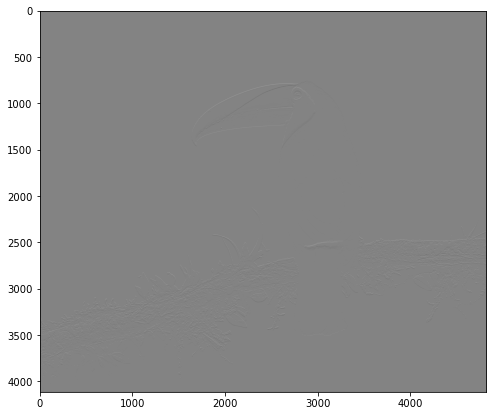

In [27]:
imshow(Iy)

Set:

$$A = \sum_{(x,y) \in W} I_x^2$$

$$B = \sum_{(x,y) \in W} I_xI_y$$

$$C = \sum_{(x,y) \in W} I_y^2$$

We have:

$$ 
\begin{aligned}
    E(x,y)
        & \approx A u^2 + 2Buv + C v^2 \\
        & \approx \begin{bmatrix}u & v\end{bmatrix}
        \begin{bmatrix}A & B \\ B & C\end{bmatrix}
        \begin{bmatrix}u & v\end{bmatrix}
\end{aligned}
$$

https://courses.cs.washington.edu/courses/cse455/09wi/Lects/lect6.pdf